In [65]:
import numpy  as np
import pandas as pd
from imageio import imread
import glob
import time
import os

import warnings
warnings.filterwarnings('ignore')

###############################################################################################################################
# BASICS AND GLOBALS

PATH = 'C:/Users/Alberto/MisCosas/H5canvas/'

###############################################################################################################################
# LOADING IMAGES

# cargar las imagenes y darle los colores elegidos    
def carga(file):
    # print(file)
    m = np.array(imread(file)).astype('uint8')
    # si la imagen ya tiene color, carga tal cual
    if structurefile(file)[2].split('_')[0]=='RGB':
        return m
    else:
        jm,im,k=m.shape
        # se asume que el png es transparente (0), cualquier color (1), blanco (2) o negro (3
        n = np.full((jm,im),0)
        n[ m[:,:,3]==0] = 0
        n[(m[:,:,3]==255)&(~((m[:,:,0]==255)&(m[:,:,1]==255)&(m[:,:,2]==255)))] = 1
        n[(m[:,:,3]==255)&   (m[:,:,0]==255)&(m[:,:,1]==255)&(m[:,:,2]==255)  ] = 2
        n[(m[:,:,3]==255)&   (m[:,:,0]==  0)&(m[:,:,1]==  0)&(m[:,:,2]==  0)  ] = 3
        return n

def splitbypoint(y):
    y = y.split('.')
    if len(y)==2:
        y = y[0:1]+['0','0','0','0','0','png']
    return y
def structurefile(x):
    xx = [ splitbypoint(y) for y in x.split('\\')[-3:]]
    return np.concatenate(xx)[:-1]

# cargar todos los elementos siguiendo el arbol de carpetas
def load_tiles(path):
    filespanel = glob.glob(path+'images/panel/*/*.png')
    # no cargamos las imagenes de la intro si no está activada la opcion
    filespanel = [x for x in filespanel 
        if ((x.split('\\')[-2]!='videointro') and (not False)) or (False) ]
    files      = glob.glob(path+'images/*/*/*.png')
    
    tiles = pd.DataFrame([ structurefile(x) for x in files if not x in filespanel],
                         columns=['type','folder','file','I','J','DX','DY','DZ'])
    tiles['I']   = tiles['I'].astype(int)
    tiles['J']   = tiles['J'].astype(int)
    tiles['DX']  = tiles['DX'].astype(int)
    tiles['DY']  = tiles['DY'].astype(int)
    tiles['DZ']  = tiles['DZ'].astype(int)
    tiles['png'] = [carga(x) for x in files if x not in filespanel]
    tiles['DI']  = tiles['png'].apply(lambda r: r.shape[1])
    tiles['DJ']  = tiles['png'].apply(lambda r: r.shape[0])
    
    tilespanel = pd.DataFrame([ structurefile(x)[[-7,-6]] for x in filespanel],columns=['type','file'])
    tilespanel['png'] = [carga(x) for x in filespanel]
    tilespanel['DI']  = tilespanel['png'].apply(lambda r: r.shape[1])
    tilespanel['DJ']  = tilespanel['png'].apply(lambda r: r.shape[0])

    return tiles.set_index(['type','folder','file'])[['I','J','DI','DJ','DX','DY','DZ','png']],tilespanel.set_index(['type','file'])
    
# cargamos imagenes
tiles,tilespanel = load_tiles(PATH)

abc = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,'"+'"?!@*#$%&()+-/:;<=>[\]^{|}~ ';

GOTHIC = tilespanel.loc[('text','mygothic')].png
GOTHICFAT = tilespanel.loc[('text','mygothicfat')].png

def getmatrix(k):
    i,j=k%7,k//7
    M = GOTHIC[63*j:63*(j+1),91*i:91*(i+1)]
    if k!=92:
        h = M[:,:].sum(axis=0)!=0
        MM = M[:,h]
    else:
        MM = M[:,0:12]
    return MM

def getmatrixfat(k):
    i,j=k%7,k//7
    M = GOTHICFAT[63*j:63*(j+1),91*i:91*(i+1)]
    if k!=92:
        h = M[:,:].sum(axis=0)!=0
        MM = M[:,h]
    else:
        MM = M[:,0:12]
    return MM

In [66]:


# creamos una entrada por cada letra, desechamos el archivo completo
letters1 = pd.DataFrame({'type':'panel','folder':'text_normal','file':list(abc),'I':0,'J':0,'DI':6,'DJ':11,
                                   'DX':0,'DY':0,'DZ':0,
                'png':[tiles.loc['panel','text','all_white_6'].png[:,k*6:(k+1)*6] for k in range(len(abc))]})
#               'png':[tiles.loc['panel','text','all_white_6'].png[0][:,k*6:(k+1)*6] for k in range(len(abc))]})
# por razon desconocida a aveces necesita el [0]

letters2 = pd.DataFrame({'type':'panel','folder':'text_gothic','file':list(abc),'I':0,'J':0,
                         'DI':[getmatrix(k).shape[1] for k in range(len(abc))],
                         'DJ':[getmatrix(k).shape[0] for k in range(len(abc))],
                         'DX':0,'DY':0,'DZ':0,
                'png':[getmatrix(k) for k in range(len(abc))]})

letters3 = pd.DataFrame({'type':'panel','folder':'text_gothic_fat','file':list(abc),'I':0,'J':0,
                         'DI':[getmatrixfat(k).shape[1] for k in range(len(abc))],
                         'DJ':[getmatrixfat(k).shape[0] for k in range(len(abc))],
                         'DX':0,'DY':0,'DZ':0,
                'png':[getmatrixfat(k) for k in range(len(abc))]})
letters = pd.concat([letters1,letters2,letters3])

tiles0 = tiles.reset_index()
tiles0 = pd.concat([tiles0[tiles0['folder']!='text'],letters])

# pasamos a formatos que se traga el JS
tiles0['folder'] = tiles0['folder'].apply(lambda r: r.replace('-','_'))
tiles0['png']    = tiles0['png'].apply(lambda r: r.flatten().tolist())
tiles0 = tiles0[~((tiles0['type']=='panel')&(tiles0['folder']=='videointro'))]


culo = {tt:{ff:{f:tiles0[(tiles0['type']==tt)&(tiles0['folder']==ff)&(tiles0['file']==f)].drop(columns=['type','folder','file']).iloc[0].to_dict() 
                    for f in tiles0[(tiles0['type']==tt)&(tiles0['folder']==ff)]['file'].drop_duplicates()} 
                for ff in tiles0[tiles0['type']==tt]['folder'].drop_duplicates()}
            for tt in tiles0['type'].drop_duplicates()}

with open('../H5canvas/code/js/tiles.js', 'w') as jsfile:
    jsfile.write("tiles = "+str(culo))

In [101]:


txt = ["python -mrjsmin <"+x+">"+x.replace('/js','/minijs') for x in glob.glob('code/js/*.js')]
for t in txt:
    !{t}
txt

filenames = glob.glob('code/minijs/*.js')
with open('code/minijs/ice.js', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())
for fname in filenames:
    os.remove(fname)

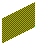

In [56]:
WINDOW = tiles.loc['structures','hotelwindow','windowglass'].png
def getmatrixwindow(k):
    i,j=k%4,k//4
    M = WINDOW[4*j:4*(j+1),4*i:4*(i+1)]
    return M

display(fromarray(proyecta([tiles.loc[('structures','hotelwindow','windowglass')].png,
                            [[0,255,0,255],[255,0,0,255]]]).astype('uint8')))

In [64]:
[k for k in range(44) if getmatrixwindow(k).sum()>0]

[14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41]

In [1]:
626250/15623

40.085130896754784

In [28]:
types = tiles0['type'].drop_duplicates()
for i in range(len(types)):
    culo = {tt:{ff:{f:tiles0[(tiles0['type']==tt)&(tiles0['folder']==ff)&(tiles0['file']==f)].drop(columns=['type','folder','file']).iloc[0].to_dict() 
                        for f in tiles0[(tiles0['type']==tt)&(tiles0['folder']==ff)]['file'].drop_duplicates()} 
                    for ff in tiles0[tiles0['type']==tt]['folder'].drop_duplicates()}
                for tt in [types.iloc[i]]}
    with open('../H5canvas/tiles/tiles'+str(i)+'.json', 'w') as json_file:
        json_file.write("tiles"+str(i)+'= '+str(culo))

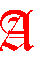

In [31]:
from PIL.Image import fromarray
def proyecta(pngclrs12):
    png,clrs12=pngclrs12
    # asumimos que el 3er color es negro
    clrs12 += [0,0,0,255]    
    b = np.repeat(np.expand_dims(png, axis=2), 4, axis=2)
    for c in range(len(clrs12)):
        b = np.where(b == np.repeat(c+1,4), clrs12[c], b)
    return b

display(fromarray(proyecta([getmatrix(0),[[0,0,0,255],[255,0,0,255]]]).astype('uint8')))

In [39]:
tiles.loc['panel','text','all_white_6'].png[0]

array([0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0,
       2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
       2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [47]:
x=np.array(culo['people']['guy_cool']['m0_10N']['png'])
len(x[x!=0]),len(x)

(386, 1280)

In [ ]:
x=np.array(culo['people']['guy_cool']['m0_10N']['png'])
len(x[x!=0]),len(x)

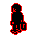

In [51]:
display(fromarray(proyecta([tiles.loc[('people','guy_cool','m0_10N')].png,[[0,0,0,255],[255,0,0,255]]]).astype('uint8')))

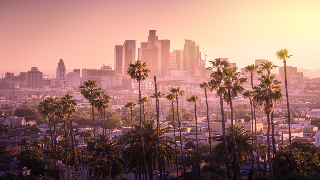

In [26]:
from PIL.Image import fromarray
display(fromarray(tiles.loc[('panel','cover','RGB_LA')].png.astype('uint8')))

In [19]:
tiles.head()

I  J  DI  DJ  DX  DY  DZ  \
type  folder          file                                
doors club-door-back  closed   4  1  23  46   8   3  36   
                      frame    4  1   7  34   1   3  36   
                      open    20  0  23  53   1  11  36   
      club-door-front closed   3  0  21  45   8   1  36   
                      frame    5  0   7  34   1   1  36   

                                                                            png  
type  folder          file                                                       
doors club-door-back  closed  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
                      frame   [[0, 0, 2, 2, 2, 2, 1], [2, 2, 2, 1, 1, 2, 1],...  
                      open    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
      club-door-front closed  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
                      frame   [[0, 0, 2, 2, 2, 2, 0], [2, 2, 2, 1, 1, 2, 0],...